In [4]:
import os
import random
import numpy as np
from PIL import Image,ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

In [5]:
train_dir = '/content/drive/MyDrive/skin_cancer_dataset/train'
test_dir = '/content/drive/MyDrive/skin_cancer_dataset/test'


In [6]:
# Function to gather image paths and labels from a directory
def gather_data(base_dir):
    img_files = []
    lbls = []
    sub_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for cls in sub_dirs:
        full_dir = os.path.join(base_dir, cls)
        images = os.listdir(full_dir)

        img_files.extend([os.path.join(full_dir, img) for img in images])
        lbls.extend([cls] * len(images))

    combined = list(zip(img_files, lbls))
    random.shuffle(combined)
    paths, labels = zip(*combined)
    return list(paths), list(labels)

# Load and shuffle training data
train_imgs, train_classes = gather_data(train_dir)

# Load and shuffle testing data
test_imgs, test_classes = gather_data(test_dir)

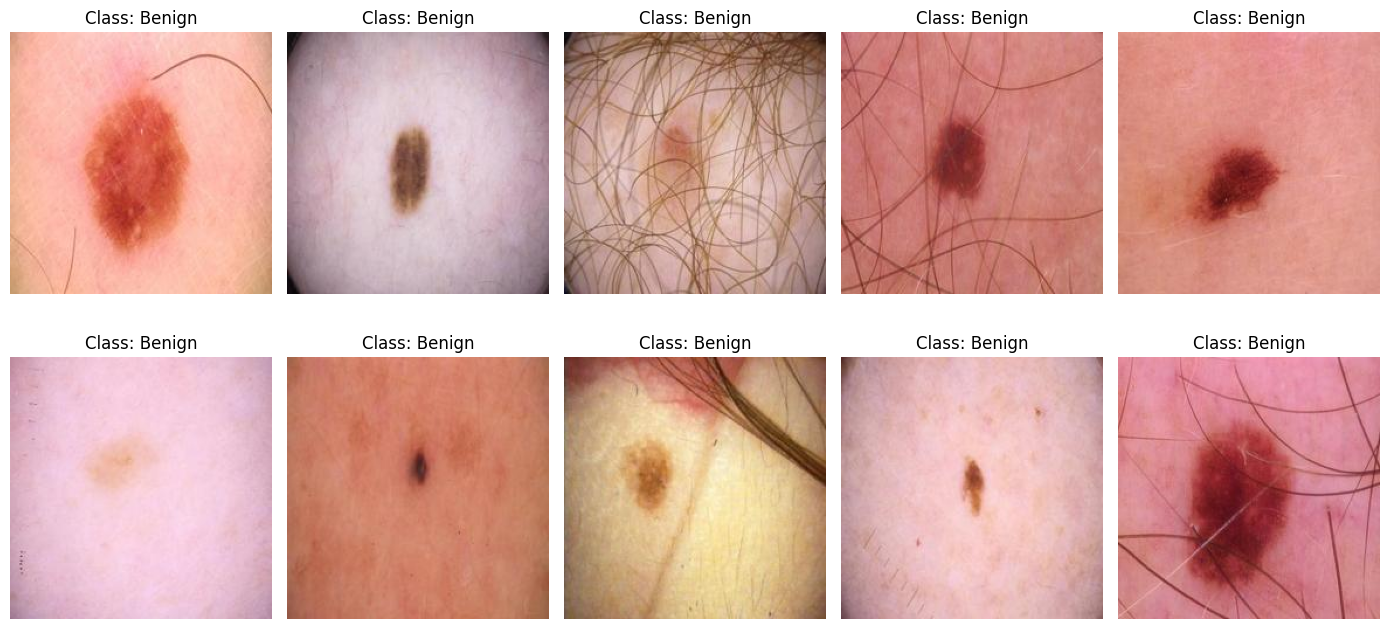

In [7]:
import matplotlib.pyplot as plt

# Display a few random training images
def preview_images(image_paths, labels, count=10):
    chosen = random.choices(range(len(image_paths)), k=count)

    fig, ax_grid = plt.subplots(2, 5, figsize=(14, 7))
    ax_grid = ax_grid.flatten()

    for plot_idx, data_idx in enumerate(chosen):
        image = Image.open(image_paths[data_idx]).resize((224, 224))
        ax_grid[plot_idx].imshow(image)
        ax_grid[plot_idx].set_title(f"Class: {labels[data_idx]}", fontsize=12)
        ax_grid[plot_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Call visualization
preview_images(train_imgs, train_classes)

In [8]:
#data preprocessing

# Image Augmentation
import random
import numpy as np
from PIL import Image, ImageEnhance

def augment_image(image):
    image = Image.fromarray(np.uint8(image))

    # Random brightness
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))

    # Random contrast
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

    # Random rotation (-15 to 15 degrees)
    angle = random.uniform(-15, 15)
    image = image.rotate(angle)

    # Random horizontal flip (50% chance)
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # Random vertical flip (20% chance)
    if random.random() > 0.8:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)

    # Random zoom (crop and resize)
    if random.random() > 0.5:
        width, height = image.size
        zoom_factor = random.uniform(0.9, 1.0)  # Crop between 90–100% of area
        crop_w, crop_h = int(width * zoom_factor), int(height * zoom_factor)
        left = random.randint(0, width - crop_w)
        top = random.randint(0, height - crop_h)
        image = image.crop((left, top, left + crop_w, top + crop_h))
        image = image.resize((width, height))

    # Normalize to [0,1]
    image = np.array(image) / 255.0
    return image


# Load images and apply augmentation
def open_images(paths, labels):
    images = []
    new_labels = []
    for path, label in zip(paths, labels):
        try:
            image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            image = augment_image(image)
            images.append(image)
            new_labels.append(label)
        except Exception as e:
            print(f"[Warning] Skipped file: {path} due to error: {e}")
    return np.array(images), new_labels

# Encoding labels
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images, valid_labels = open_images(batch_paths, batch_labels)
            valid_labels = encode_label(valid_labels)
            yield batch_images, valid_labels

In [9]:
# Define input dimensions and load base model
IMAGE_SIZE = 128
vgg_backbone = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all layers initially
for lyr in vgg_backbone.layers:
    lyr.trainable = False

# Selectively unfreeze the last few layers for fine-tuning
for lyr in vgg_backbone.layers[-4:-1]:
    lyr.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Construct the classification model
clf_model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    vgg_backbone,
    Flatten(),
    Dropout(rate=0.3),
    Dense(units=128, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=len(os.listdir(train_dir)), activation='softmax')
])

In [11]:
# Compile the neural network
clf_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Training configuration
EPOCHS = 10
BATCH = 12
steps_per_epoch = len(train_imgs) // BATCH

# Model training loop
training_log = clf_model.fit(
    datagen(train_imgs, train_classes, batch_size=BATCH, epochs=EPOCHS),
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 2332s 2s/step - loss: 0.4269 - sparse_categorical_accuracy: 0.8084
Epoch 2/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 58ms/step - loss: 0.3116 - sparse_categorical_accuracy: 0.8666
Epoch 3/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 0.2912 - sparse_categorical_accuracy: 0.8745
Epoch 4/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - loss: 0.2801 - sparse_categorical_accuracy: 0.8839
Epoch 5/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.8849
Epoch 6/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.8923
Epoch 7/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - loss: 0.2452 - sparse_categorical_accuracy: 0.8991
Epoch 8/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 0.2370 - sparse_categorical_accuracy: 0.9007
Epoch 9/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 0.2285 - sparse_categorical_accuracy: 0.9041
Epoch 10/10
994/994 ━━━━━━━━━━━━━━━━━

In [12]:
import os
os.makedirs("saved_models", exist_ok=True)

# Save the full model (architecture + weights + optimizer state)
model_path = "saved_models/skincancer.h5"
clf_model.save(model_path)

In [13]:
import os
os.makedirs("saved_models", exist_ok=True)

# Save the full model (architecture + weights + optimizer state)
model_path = "saved_models/skincancerdetection.h5"
clf_model.save(model_path)

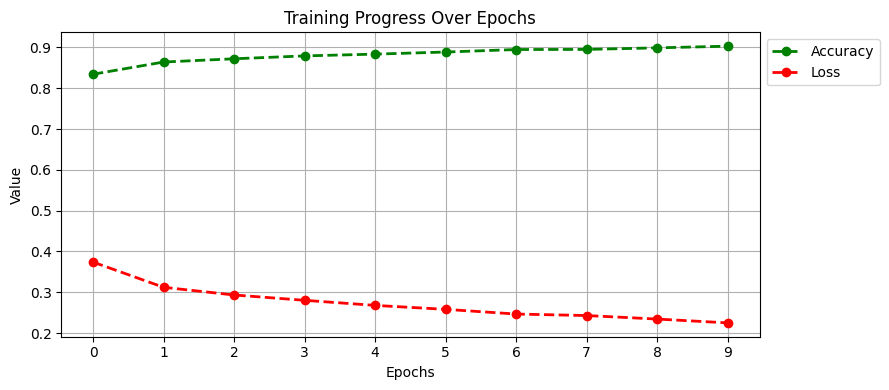

In [14]:
metrics = training_log.history

plt.figure(figsize=(9, 4))
plt.plot(metrics['sparse_categorical_accuracy'], 'go--', linewidth=2, label='Accuracy')
plt.plot(metrics['loss'], 'ro--', linewidth=2, label='Loss')
plt.title("Training Progress Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(visible=True)
plt.xticks(ticks=list(range(EPOCHS)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import seaborn as sns
import numpy as np

# Load test data
eval_images, eval_labels = open_images(test_imgs, test_classes)
encoded_eval_labels = encode_label(eval_labels)

# Make predictions
pred_outputs = clf_model.predict(eval_images)
predicted_eval_classes = np.argmax(pred_outputs, axis=1)

# Display classification report
print("Model Evaluation Report:")
print(classification_report(encoded_eval_labels, predicted_eval_classes))

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step
Model Evaluation Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1000
           1       0.92      0.85      0.88      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [18]:
print("y_true_bin shape:", y_true_bin.shape)
print("y_pred_bin shape:", y_pred_bin.shape)

y_true_bin shape: (2000, 1)
y_pred_bin shape: (2000, 2)


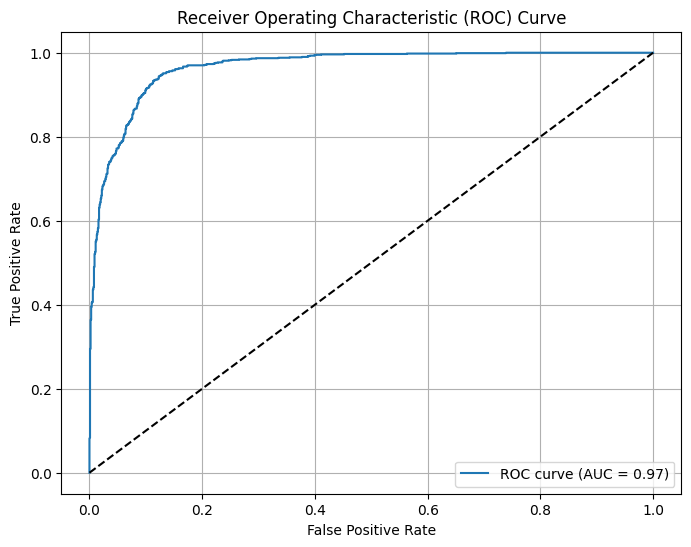

In [19]:
# Get ground-truth binary labels (flatten to shape (2000,))
y_true_bin = encoded_eval_labels  # already encoded, shape (2000,)
# Get predicted probabilities for the positive class (class 1)
y_score = y_pred_bin[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [21]:
print("encoded_eval_labels shape:", encoded_eval_labels.shape)
print("Unique labels:", np.unique(encoded_eval_labels))
y_true_bin = label_binarize(encoded_eval_labels, classes=[0, 1])
print("y_true_bin shape:", y_true_bin.shape)
print("y_pred_bin shape:", y_pred_bin.shape)


encoded_eval_labels shape: (2000,)
Unique labels: [0 1]
y_true_bin shape: (2000, 1)
y_pred_bin shape: (2000, 2)


In [23]:
print("Class counts:", np.bincount(encoded_eval_labels))


Class counts: [1000 1000]


In [24]:


# Force labels to be numpy array of int
encoded_eval_labels = np.array(encoded_eval_labels, dtype=int)

# Force both class columns (important!)
y_true_bin = label_binarize(encoded_eval_labels, classes=[0, 1])  # (2000, 2)

# Sanity check
print("y_true_bin shape:", y_true_bin.shape)  # Should be (2000, 2)
print("y_pred_bin shape:", y_pred_bin.shape)  # Should be (2000, 2)

# Compute ROC for both classes
fpr_dict, tpr_dict, auc_dict = {}, {}, {}
for cls_idx in [0, 1]:
    fpr_dict[cls_idx], tpr_dict[cls_idx], _ = roc_curve(y_true_bin[:, cls_idx], y_pred_bin[:, cls_idx])
    auc_dict[cls_idx] = auc(fpr_dict[cls_idx], tpr_dict[cls_idx])

# Plot ROC
plt.figure(figsize=(10, 8))
for cls_idx in [0, 1]:
    plt.plot(fpr_dict[cls_idx], tpr_dict[cls_idx], label=f'Class {cls_idx} (AUC = {auc_dict[cls_idx]:.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve for Class 0 and Class 1")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



y_true_bin shape: (2000, 1)
y_pred_bin shape: (2000, 2)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [17]:
# One-hot encode the true labels
y_true_bin = label_binarize(encoded_eval_labels, classes=np.arange(len(os.listdir(train_dir))))
y_pred_bin = pred_outputs

# Store metrics for each class
fpr_dict, tpr_dict, auc_dict = {}, {}, {}
num_classes = len(os.listdir(train_dir))

for cls_idx in range(num_classes):
    fpr_dict[cls_idx], tpr_dict[cls_idx], _ = roc_curve(y_true_bin[:, cls_idx], y_pred_bin[:, cls_idx])
    auc_dict[cls_idx] = auc(fpr_dict[cls_idx], tpr_dict[cls_idx])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for cls_idx in range(num_classes):
    plt.plot(fpr_dict[cls_idx], tpr_dict[cls_idx], label=f'Class {cls_idx} (AUC = {auc_dict[cls_idx]:.2f})')

# Reference diagonal
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# One-hot encode the true labels
num_classes = len(os.listdir(train_dir))
class_list = np.arange(num_classes)

y_true_bin = label_binarize(encoded_eval_labels, classes=class_list)
y_pred_bin = np.array(pred_outputs)  # probabilities from your model

# Store metrics
fpr_dict, tpr_dict, auc_dict = {}, {}, {}

if num_classes == 2:
    # Binary case
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Binary Classification)")
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multiclass case
    plt.figure(figsize=(10, 8))
    for cls_idx in range(num_classes):
        fpr_dict[cls_idx], tpr_dict[cls_idx], _ = roc_curve(
            y_true_bin[:, cls_idx], y_pred_bin[:, cls_idx]
        )
        auc_dict[cls_idx] = auc(fpr_dict[cls_idx], tpr_dict[cls_idx])
        plt.plot(fpr_dict[cls_idx], tpr_dict[cls_idx],
                 label=f'Class {cls_idx} (AUC = {auc_dict[cls_idx]:.2f})')

    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Number of classes from training set
num_classes = len(os.listdir(train_dir))

# Force label_binarize to have full class range, even if missing in test set
y_true_bin = label_binarize(encoded_eval_labels, classes=np.arange(num_classes))
y_pred_bin = pred_outputs

# If only 1 class present in test set, label_binarize returns shape (N, 1)
# We pad columns so indexing works for all classes
if y_true_bin.shape[1] != num_classes:
    y_true_bin = np.hstack([
        y_true_bin,
        np.zeros((y_true_bin.shape[0], num_classes - y_true_bin.shape[1]))
    ])
    y_pred_bin = np.hstack([
        y_pred_bin,
        np.zeros((y_pred_bin.shape[0], num_classes - y_pred_bin.shape[1]))
    ])

# Store results
fpr_dict, tpr_dict, auc_dict = {}, {}, {}

# Compute ROC only for classes that appear in y_true_bin
for cls_idx in range(num_classes):
    if np.sum(y_true_bin[:, cls_idx]) > 0:  # Avoid empty class in test set
        fpr_dict[cls_idx], tpr_dict[cls_idx], _ = roc_curve(
            y_true_bin[:, cls_idx], y_pred_bin[:, cls_idx]
        )
        auc_dict[cls_idx] = auc(fpr_dict[cls_idx], tpr_dict[cls_idx])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for cls_idx, auc_score in auc_dict.items():
    plt.plot(
        fpr_dict[cls_idx], tpr_dict[cls_idx],
        label=f'Class {cls_idx} (AUC = {auc_score:.2f})'
    )

# Diagonal reference line
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()